Побудована нейронна мережа клас VGG-16 є реалізацією моделі VGG з архітектурою, що складається з власне ознак (features) та класифікатора. 
Спочатку проводимо розрахунок відхилень по кожному каналу. За допомогою послідовності перетворень(обертання, віддзеркаленням, додавання пікселів і вирізання випадкової частини)перетворюємо зображення у тензор Pytorch і нормалізуємо зображення. Розділяємо дані на проходження перевірки - 90% даних використані для навчання моделі, а інші 10 % для валідації та результатів. Створюємо послідовність згорткових  шарів (Conv2d). Це список, що визначає конфігурацію мережі VGG. Кожен елемент цього списку може бути цілим числом (яке визначає кількість вихідних каналів для Conv2d шару) або 'M', що вказує на MaxPooling шар. Отже, функція get_vgg_layers дозволяє швидко створити модель VGG з визначеною конфігурацією шарів та налаштуваннями батч-нормалізації.
Завантажуємо модель VGG_11_bn з попередньо навченими вагами з набору даних ImageNet наприклад, модель від PyTorch, яка має атрибут "classifier". Тут використаємо метод встановлення швидкості навчання, який виключає необхідність експериментально знаходити найкращі значення та графік самого навчання, що забезпечує підвищену точність класифікації клас LRFinder. Це зображено на графіку залежності швидкостей навчання від втрат. Функція побудови невірних передбачень допомагає візуалізувати найбільш неправильно класифіковані зображення під час навчання моделі, що є важливим для аналізу результатів та виявлення проблем у моделі.
На інших двох графіках зображено графіки втрат на тренувальному та валідаційному наборі. 
Точність на наборах збільшується з кожною епохою, що свідчить про навчання моделі. Якщо точність на валіаційному наборі починає стагнувати, тоді модель перенавчається. Так як модель отримала досить високі показники точності 93%, то налаштування гіпермпараметрів обрано вірно.


In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

from sklearn import decomposition, manifold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

# Load Data

Set transformations to apply to training set and valid/test set

In [2]:
# pretrained means and standard deviations from ImageNet dataset
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize(pretrained_size),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(pretrained_size, padding=10),
    transforms.ToTensor(),
    transforms.Normalize(mean = pretrained_means,
                         std = pretrained_stds)
])

test_transforms = transforms.Compose([
    transforms.Resize(pretrained_size),
    transforms.ToTensor(),
    transforms.Normalize(mean = pretrained_means,
                         std = pretrained_stds)
])

Download data

In [3]:
ROOT = '.data'

train_data = datasets.CIFAR10(root=ROOT,
                              train=True,
                              download=True,
                              transform=train_transforms)

test_data = datasets.CIFAR10(root=ROOT,
                             train=False,
                             download=True,
                             transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


Split training set to a smaller training set and a validation set

In [4]:
VALID_RATIO = 0.9
n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

In [5]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [6]:
print('Number of training examples:', len(train_data))
print('Number of validation examples:', len(valid_data))
print('Number of test examples:', len(test_data))

Number of training examples: 45000
Number of validation examples: 5000
Number of test examples: 10000


In [7]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min=image_min, max=image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

In [8]:
def plot_images(images, labels, classes, normalize=True):
  n_images = len(images)
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize=(7,7))

  for i in range(n_images):
    ax = fig.add_subplot(rows, cols, i+1)
    image = images[i]
    if normalize:
      image = normalize_image(image)
    ax.imshow(image.permute(1,2,0).cpu().numpy())
    ax.set_title(classes[labels[i]])
    ax.axis('off')

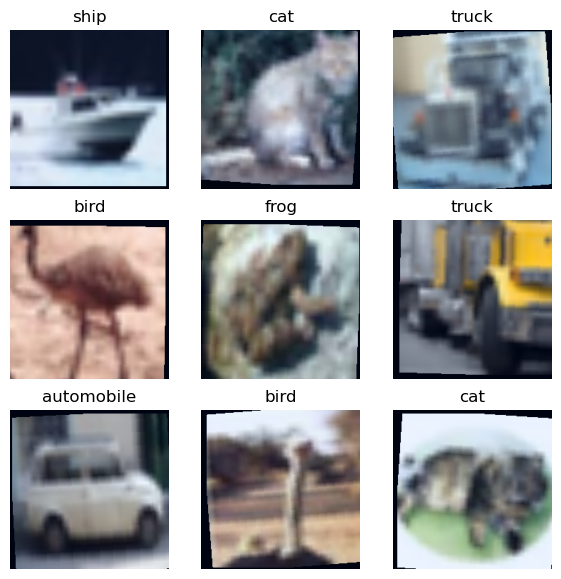

In [9]:
N_IMAGES = 9

images, labels = zip(*[(image, label) for image, label 
                       in [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

# Configure Model

Create class VGG that represent the VGG model family

In [10]:
class VGG(nn.Module):
  def __init__(self, features, output_dim):
    super().__init__()

    self.features = features

    self.avgpool = nn.AdaptiveAvgPool2d(7)

    self.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, output_dim),
    )

  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    h = x.view(x.shape[0], -1)
    output = self.classifier(h)
    return output, h

In [11]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 
                512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 
                512, 512, 512, 'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 
                512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

In [12]:
def get_vgg_layers(config, batch_norm):
  layers = []
  in_channels = 3

  for c in config:
    assert c == 'M' or isinstance(c, int)
    if c == 'M':
      layers += [nn.MaxPool2d(2)]
    else:
      conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
      
      if batch_norm:
        layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
      else:
        layers += [conv2d, nn.ReLU(inplace=True)]

      in_channels = c

  return nn.Sequential(*layers)

In [13]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)

In [14]:
vgg11_layers

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [15]:
OUTPUT_DIM = 10
model = VGG(vgg11_layers, OUTPUT_DIM)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

Load pretrained model 

In [16]:
pretrained_model = models.vgg11_bn(weights='IMAGENET1K_V1')
pretrained_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [17]:
# Replace the final layer of the pretrained model
IN_FEATURES = pretrained_model.classifier[-1].in_features
final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.classifier[-1] = final_fc

In [18]:
pretrained_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

In [19]:
# Load weights of pretrained model to the model we defined above
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [20]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
             
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 128,812,810 trainable parameters


# Train Model

## Find suitable learning rate with Learning Rate Finder algorithm

Steps:
- Set the learning rate of optimizer with a much lower value than expected to use
- Train the model with one epoch. Calculate the loss for each batch and increase learning rate exponentially
- Keep repeating step 2 until the loss diverges or reaching maximum learning rate
- Plot losses over different learning rates and pick the most suitable value for training

Reference: https://arxiv.org/abs/1506.01186

In [21]:
BATCH_SIZE = 128

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size = BATCH_SIZE)

In [22]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [23]:
class LRFinder:
  def __init__(self, model, optimizer, criterion, device):
    self.model = model
    self.optimizer = optimizer
    self.criterion = criterion
    self.device = device
    torch.save(model.state_dict(), 'init_params.pt')

  def _train_batch(self, iterator):
    self.model.train()
    self.optimizer.zero_grad()
    x, y = iterator.get_batch()
    x = x.to(self.device)
    y = y.to(self.device)
    y_pred, _ = model(x)
    loss = self.criterion(y_pred, y)
    loss.backward()
    self.optimizer.step()
    return loss.item()

  def range_test(self, iterator, end_lr=10, num_iter=100,
                 smooth_f=0.05, diverge_th=5):
    lrs=[]
    losses=[]
    best_loss = float('inf')

    lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
    iterator = IteratorWrapper(iterator)

    for iteration in range(num_iter):
      loss = self._train_batch(iterator)
      lrs.append(lr_scheduler.get_last_lr()[0])
      
      # update lr
      lr_scheduler.step()

      if iteration > 0:
        loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
      
      if loss < best_loss:
        best_loss = loss
      
      losses.append(loss)

      if loss > diverge_th * best_loss:
        print("Stopping early, the loss has diverged")
        break

    # reset model to initial parameters
    model.load_state_dict(torch.load('init_params.pt'))
    return lrs, losses

class ExponentialLR(_LRScheduler):
  def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
    self.end_lr = end_lr
    self.num_iter = num_iter
    super().__init__(optimizer, last_epoch)

  def get_lr(self):
    cur_iter = self.last_epoch
    r = cur_iter / self.num_iter
    return [base_lr * ((self.end_lr / base_lr) ** r) for base_lr in self.base_lrs]

class IteratorWrapper():
  def __init__(self, iterator):
    self.iterator = iterator
    self._iterator = iter(iterator)

  def __next__(self):
    try:
      inputs, labels = next(self._iterator)
    except StopIteration:
      self._iterator = iter(self.iterator)
      inputs, labels, *_ = next(self._iterator)
    return inputs, labels

  def get_batch(self):
    return next(self)

Based on the provided code snippet, it seems you are using the LR Finder (LRFinder) to perform a range test to find an optimal learning rate. Here's a brief explanation of the provided code and how it's used:
Make sure that model, optimizer, criterion, device, and train_iterator are properly defined and instantiated before running this code. This LR range test can help you determine an appropriate learning rate for training your neural network effectively.

In [25]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [26]:
def plot_lr_finder(lrs, losses, skip_start=5, skip_end=5):
  if skip_end == 0:
    lrs = lrs[skip_start:]
    losses = losses[skip_start:]
  else:
    lrs = lrs[skip_start:-skip_end]
    losses = losses[skip_start:-skip_end]

  fig = plt.figure(figsize=(16,8))
  ax = fig.add_subplot(1,1,1)
  ax.plot(lrs, losses)
  ax.set_xscale('log')
  ax.set_xlabel('Learning rate')
  ax.set_ylabel('Loss')
  ax.grid(True, 'both', 'x')
  plt.show()

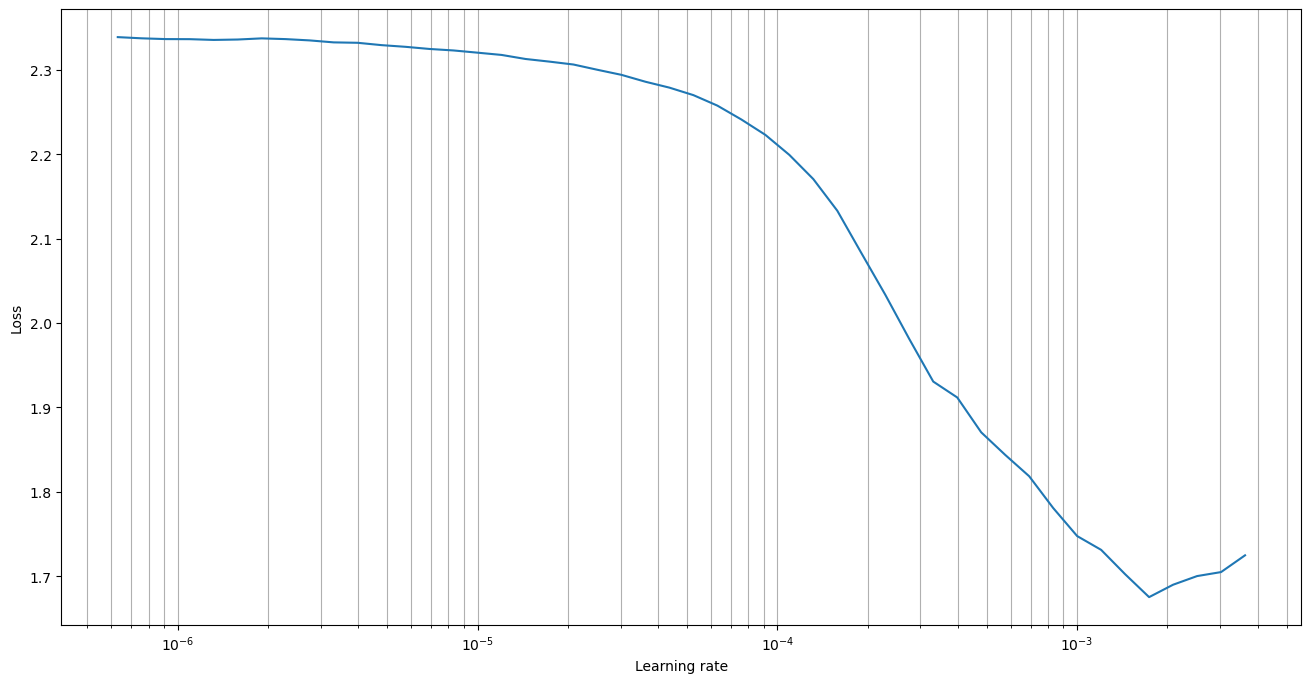

In [ ]:
plot_lr_finder(lrs, losses, skip_start=10, skip_end=20)

The lowest point is around 1e-3, divide by 10 to get 1e-4 as the recommended learning rate

## Perform transfer learning using Discriminative Fine-tuning

Intuition: When doing discriminative fine-tuning, a much smaller learning rate is used for earlier layers since low-level features are similar across diferent datasets while a larger learning rate is used for later layers to tailor for high-level features that are specific for individual dataset

Reference: https://arxiv.org/abs/1801.06146

In [27]:
FOUND_LR = 1e-4

# pass a list of dictionaries to the optimizer 
params = [
    {'params': model.features.parameters(), 'lr': FOUND_LR / 10},
    {'params': model.classifier.parameters()}
]

optimizer = optim.Adam(params, lr=FOUND_LR)

In [28]:
def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(axis=1, keepdims=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

In [29]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0
  model.train()
  for (x,y) in tqdm(iterator, desc='Training', leave=False):
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    y_pred, _ = model(x)
    loss = criterion(y_pred, y)
    acc = calculate_accuracy(y_pred, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [30]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0
  model.eval()

  with torch.no_grad():
    for (x, y) in tqdm(iterator, desc='Evaluating', leave=False):
      x = x.to(device)
      y = y.to(device)
      y_pred, _ = model(x)
      loss = criterion(y_pred, y)
      acc = calculate_accuracy(y_pred, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [31]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_min = int(elapsed_time/60)
  elapsed_secs = int(elapsed_time - elapsed_min * 60)
  return elapsed_min, elapsed_secs

In [32]:
EPOCHS=6
best_valid_loss = float('inf')

for epoch in trange(EPOCHS):
  start_time = time.monotonic()

  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'vgg-transfer-model.pt')

  end_time = time.monotonic()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\tVal. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 147m 3s
	Train Loss: 0.540 | Train Acc: 81.29%
	Val. Loss: 0.283 | Val. Acc: 90.20%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 146m 13s
	Train Loss: 0.277 | Train Acc: 90.46%
	Val. Loss: 0.246 | Val. Acc: 91.48%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 146m 9s
	Train Loss: 0.200 | Train Acc: 93.03%
	Val. Loss: 0.223 | Val. Acc: 91.76%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 144m 18s
	Train Loss: 0.151 | Train Acc: 94.77%
	Val. Loss: 0.208 | Val. Acc: 92.73%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 144m 32s
	Train Loss: 0.114 | Train Acc: 96.09%
	Val. Loss: 0.203 | Val. Acc: 93.05%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 144m 42s
	Train Loss: 0.086 | Train Acc: 97.02%
	Val. Loss: 0.210 | Val. Acc: 92.83%


In [ ]:
model.load_state_dict(torch.load('vgg-transfer-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test loss: {test_loss:.3f} | Test accuracy: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 0.224 | Test accuracy: 93.09%


# Result Analysis

In [33]:
def plot_image(image):
  """
  image -- tensor of shape (C,H,W)
  """
  image = copy.deepcopy(image)
  image = normalize_image(image)
  fig = plt.figure(figsize=(5,5))
  ax = fig.add_subplot(1,1,1)
  ax.imshow(image.permute(1,2,0).cpu().numpy())
  ax.axis('off')

In [34]:
def predict(image):
  """
  image -- tensor of shape (C,H,W)
  """
  image = copy.deepcopy(image)

  model.eval()
  with torch.no_grad():
    image = image.unsqueeze(0)
    image = image.to(device)
    pred_label, _ = model(image)
    pred_probs = F.softmax(pred_label, dim=-1)
    pred_value, pred_id = torch.max(pred_probs, dim=-1)
  return pred_value, pred_id

True label: truck
Pred. label: truck (100.000%)


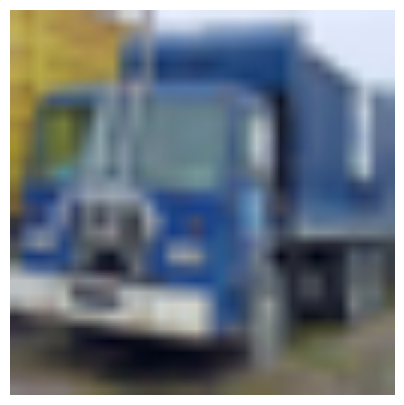

In [35]:
idx = 14

image, label = test_data[idx]

plot_image(image)

pred_value, pred_id = predict(image)

print(f'True label: {classes[label]}')
print(f'Pred. label: {classes[pred_id.item()]} ({pred_value.item()*100:.3f}%)')

In [ ]:
def get_predictions(model, iterator, device):
  model.eval()
  images = []
  labels = []
  probs = []

  with torch.no_grad():
    for (x,y) in iterator:
      x = x.to(device)
      y_pred, _ = model(x)
      y_prob = F.softmax(y_pred, dim=-1)
      images.append(x.cpu())
      labels.append(y.cpu())
      probs.append(y_prob.cpu())

  images = torch.cat(images, dim=0)
  labels = torch.cat(labels, dim=0)
  probs = torch.cat(probs, dim=0)
  
  return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator, device)
pred_labels = torch.argmax(probs, dim=1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1,1,1)
  cm = confusion_matrix(labels, pred_labels)
  cm = ConfusionMatrixDisplay(cm, display_labels=classes)
  cm.plot(values_format='d', cmap='Blues', ax=ax)
  plt.xticks(rotation=20)

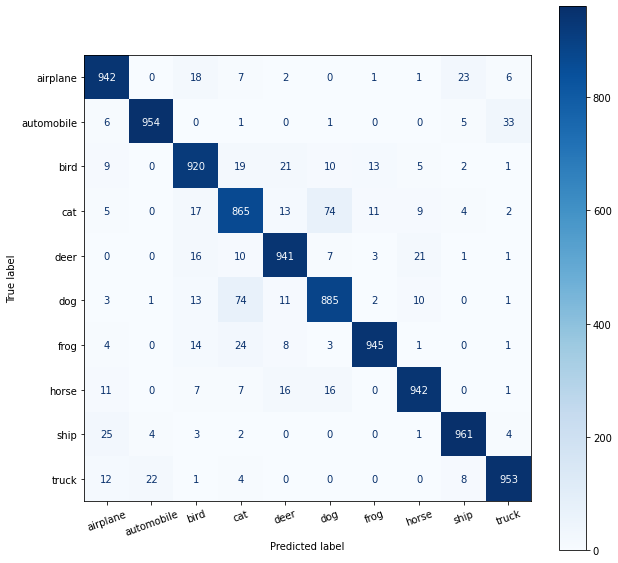

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)

In [ ]:
corrects = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
  if not correct:
    incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key = lambda x : torch.max(x[2], dim=0).values) # x[2] is prob

In [ ]:
def plot_most_incorrect(incorrect, classes, n_images, normalize=True):
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize=(25,20))

  for i in range(n_images):
    ax = fig.add_subplot(rows, cols, i+1)
    image, true_label, probs = incorrect[i]
    image = image.permute(1,2,0)
    true_prob = probs[true_label]
    incorrect_prob, incorrect_label = torch.max(probs, dim=0) 
    # needs 'dim=0' to return both value and index
    true_class = classes[true_label]
    incorrect_class = classes[incorrect_label]

    if normalize:
      normalize_image(image)

    ax.imshow(image.cpu().numpy())
    ax.set_title(f'True label: {true_class} ({true_prob:.3f})\n'
                f'Pred. label: {incorrect_class} ({incorrect_prob:.3f})')
    ax.axis('off')

  fig.subplots_adjust(hspace=0.4)

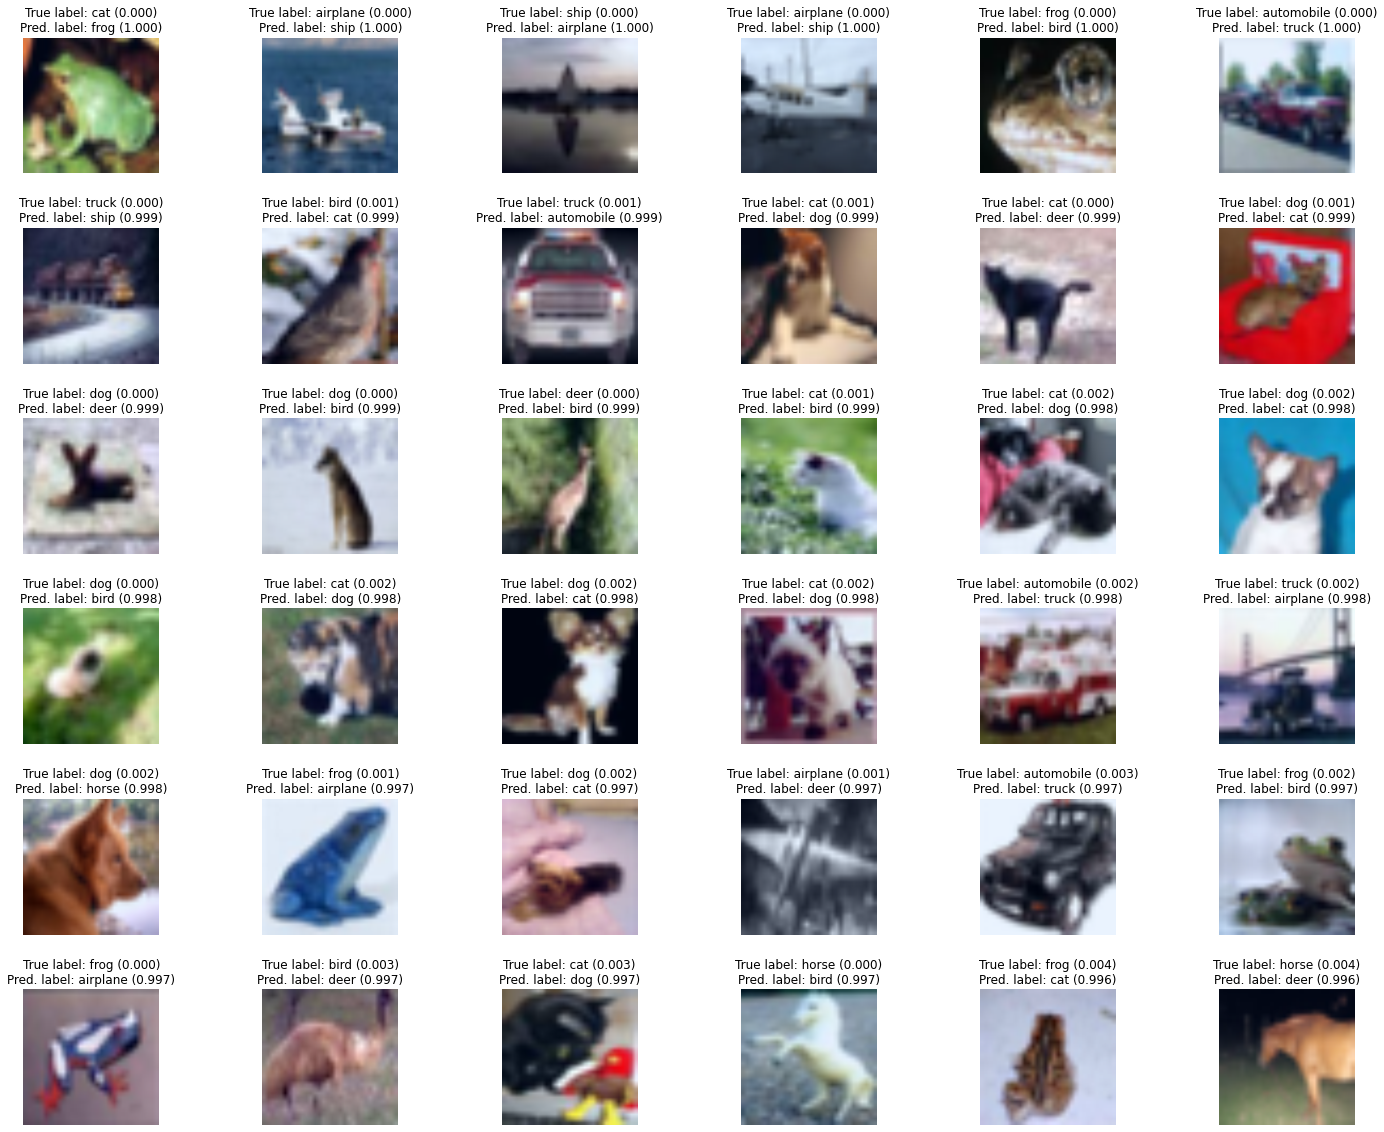

In [ ]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

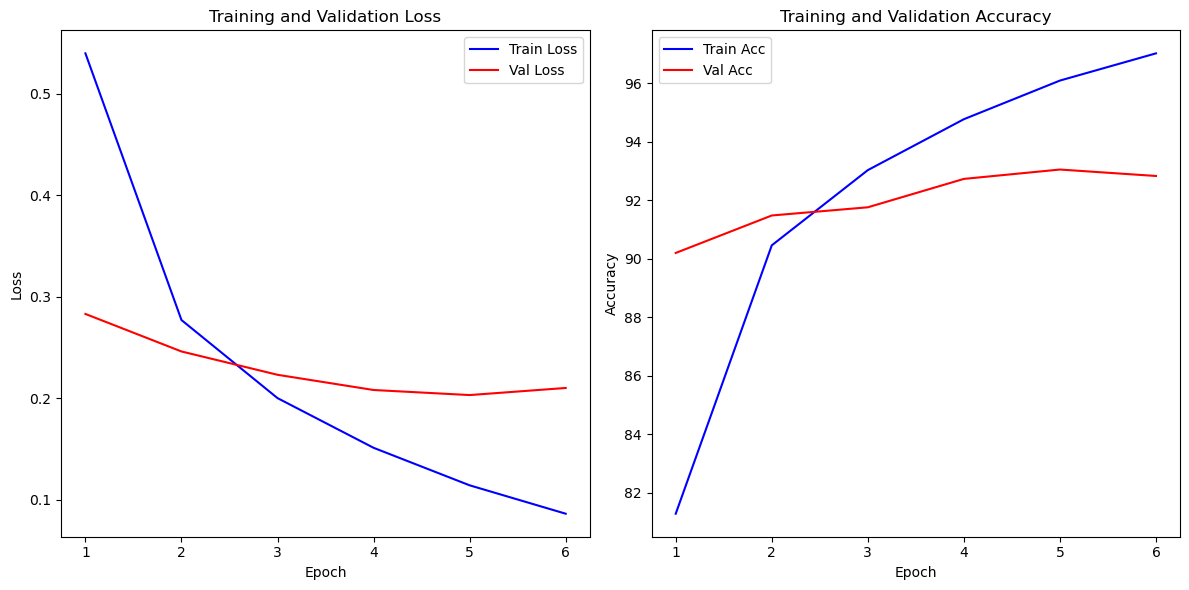

In [1]:
import matplotlib.pyplot as plt

# Дані з тренування
epochs = [1, 2, 3, 4, 5, 6]
train_losses = [0.540, 0.277, 0.200, 0.151, 0.114, 0.086]
val_losses = [0.283, 0.246, 0.223, 0.208, 0.203, 0.210]
train_accs = [81.29, 90.46, 93.03, 94.77, 96.09, 97.02]
val_accs = [90.20, 91.48, 91.76, 92.73, 93.05, 92.83]

# Побудова графіку
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, val_losses, 'r', label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, 'b', label='Train Acc')
plt.plot(epochs, val_accs, 'r', label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


It seems like you've provided the training log of a neural network model. Here's a summary of the training progress up to epoch 6:

Epoch 1:
Training Loss: 0.540
Training Accuracy: 81.29%
Validation Loss: 0.283
Validation Accuracy: 90.20%

Epoch 2:
Training Loss: 0.277
Training Accuracy: 90.46%
Validation Loss: 0.246
Validation Accuracy: 91.48%

Epoch 3:
Training Loss: 0.200
Training Accuracy: 93.03%
Validation Loss: 0.223
Validation Accuracy: 91.76%

Epoch 4:
Training Loss: 0.151
Training Accuracy: 94.77%
Validation Loss: 0.208
Validation Accuracy: 92.73%

Epoch 5:
Training Loss: 0.114
Training Accuracy: 96.09%
Validation Loss: 0.203
Validation Accuracy: 93.05%

Epoch 6:
Training Loss: 0.086
Training Accuracy: 97.02%
Validation Loss: 0.210
Validation Accuracy: 92.83%

Схоже, що втрати при навчанні та перевірці зменшуються, а точність тренування покращується з кожною епохою. Однак важливо стежити за перенавчанням, особливо якщо втрата валідації починає збільшуватися, а втрата тренування продовжує зменшуватися. В цілому, модель, здається, вчиться ефективно до цього моменту